<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [152]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [153]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-03 02:19:41--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt.3’

train.txt.3         100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2022-02-03 02:19:42 (22.9 MB/s) - ‘train.txt.3’ saved [1322055/1322055]

--2022-02-03 02:19:42--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt.3’

In [154]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [155]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [156]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [157]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [158]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words|By keeping track of the occurrences of words between documents we can train our binary document vector and train our dataset based on what words appear and do not appear when writing a positive or negative review. |0.795
|Feature 1|By taking the inverse of the frequency, we can penalize the high occurrence words and but we are able to see how often we see some words in the context of negative and positive values.|0.716
|Feature 2|Commonly, reviews give emphasis based on the capitalization of their words, while this applies for both negative and positive reviews, movie critics tend to positively emphasize good doings, actors, and directors by capitalizing their names.|0.524
|Feature 3|It takes a google search to find the most common adjectives when reviewing a movie. By creating a list of both positive and negative words, we can quantify and compare the amount of positive and negative words in a text to ultimately classify the review.|0.679

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [159]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.
    words = nltk.word_tokenize(text)
    feats = {}

    for word in words:
      feats[word] = 1
    
    return feats

In [160]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 23764, Train accuracy: 1.000, Dev accuracy: 0.795


In [161]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    #TF-IDF

    ##Bag of Words ocurrence counter
    words = nltk.word_tokenize(text)
    feats = {}

    #Get word count
    for word in words:
      if feats.get(word) == True:
        feats[word] += feats[word] + 1
      else:
        feats[word] = 1
        
    #Calculate the inverse of the word frequencies
    for key in feats.keys():
      feats[key] = (feats.get(key) / len(feats.values()))**-1
      
    return feats


In [162]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 23764, Train accuracy: 1.000, Dev accuracy: 0.716


In [163]:
from numpy.core.defchararray import isupper
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    #This feature tries to check the lenght of the text!
    #Exclamation marks, maybe here is excitement on some of the reviews, lets count how many we have
  words = nltk.word_tokenize(text)
  feats = {}
  feats["isUpper"] = 0
  
  for word in words:
        if isupper(word):
            feats["isUpper"] = feats.get("isUpper") + 1
            
  return feats

In [164]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 1, Train accuracy: 0.551, Dev accuracy: 0.524


In [165]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  positives = ["action", "amusing", "balanced", "beautiful", "breath-taking"
    "captivating", "compelling", "complex","enigmatic", "enjoyable", "entertaining", "exciting", "fantastic", "far-fetched",
    "fascinating", "funny", "gripping", "hilarious", "humorous", "inspiring", "manipulative", "masterful",
    "perfect", "powerful", "romantic","overwhelming", "perfect", "provocative", "silly", "stupid", "surprising", "super", "tense",
    "unbelievable","uplifting"]

  negatives = ["bad", "boring","confusing", "contrived", "disappointing", "far-fetched", "lousy", "manipulative","horrible",
               "imperfect", "poignant", "unrealistic", "ridiculous", "overacted", "overrated","bad","underwhelming","boring","forgettable "
               "overwhelming", "imperfect", "predictable", "provocative", "silly", "stupid", "surprising", "unoriginal","uplifting", "waste"]

  words = nltk.word_tokenize(text)
  feats = {}
  feats["contains_positive_word"] = 0
  feats["contains_negative_word"] = 0

  for word in words:
        word = word.lower()
        if word in positives:
            feats["contains_positive_word"] = feats.get("contains_positive_word") + 1
        if word in negatives:
            feats["contains_negative_word"] = feats.get("contains_negative_word") + 1
    
  return feats

In [166]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 2, Train accuracy: 0.659, Dev accuracy: 0.679


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [167]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [168]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 23767, Train accuracy: 1.000, Dev accuracy: 0.716


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


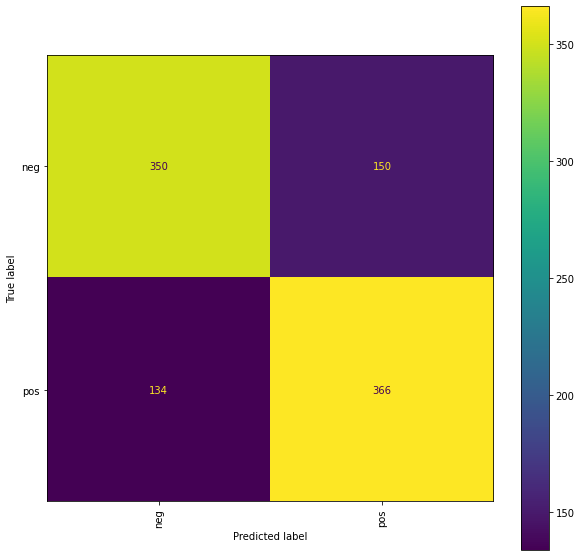

In [169]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [170]:
big_classifier.printWeights(n=25)

pos	0.039	very
pos	0.036	of
pos	0.033	enjoyed
pos	0.033	incredible
pos	0.030	gets
pos	0.030	,
pos	0.029	One
pos	0.029	fun
pos	0.028	It
pos	0.028	the
pos	0.028	excellent
pos	0.028	amazing
pos	0.026	vision
pos	0.026	remarkable
pos	0.026	human
pos	0.025	new
pos	0.025	sci-fi
pos	0.025	in
pos	0.025	beautifully
pos	0.025	perfect
pos	0.024	great
pos	0.024	romance
pos	0.024	.
pos	0.023	entertainment
pos	0.023	go

neg	-0.045	worst
neg	-0.037	would
neg	-0.036	boring
neg	-0.036	acting
neg	-0.035	even
neg	-0.034	stupid
neg	-0.030	rental
neg	-0.028	there
neg	-0.027	waste
neg	-0.026	act
neg	-0.026	dull
neg	-0.025	make
neg	-0.024	nothing
neg	-0.024	than
neg	-0.024	watching
neg	-0.023	idea
neg	-0.023	after
neg	-0.022	me
neg	-0.022	laughable
neg	-0.021	actors
neg	-0.021	're
neg	-0.021	worse
neg	-0.021	But
neg	-0.020	out
neg	-0.020	each



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [171]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [172]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1317,1.0,neg,pos,"if.... is the cinematic equivalent of Sgt. Pepper's: Revered by baby boomers as the pinnacle of creation, and viewed as rather a silly bit of business by preceding and subsequent generations. Now that the children of the middle classes the world over are seemingly super human due to the internet, and view the prospect of boarding school as a wonderful opportunity thanks to the Harry Potter boo..."
1,1337,1.0,pos,neg,FULL OF SPOILERS.This is a pretty fast and enjoyable crime thriller based on Ira Levin's play about two gay playwrights (Caine and Reeve) that plot the murder of one's rich wife (Cannon) to get the property and the insurance. The plot succeeds but Christopher Reeve as the younger and less established of the two writers decides to make a play out of the actual murder -- with only slight changes...
2,1436,1.0,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
3,1523,1.0,pos,neg,"One thing I'm sure everyone who has seen this film will agree on is that it is very creepy. The other films in Polanski's unofficial trilogy are creepy too, but they are all different in what makes them creepy, but they all roughly deal with the same thing, they all deal with the mind. Definitely the staring people are very creepy, each of them sent shivers down my spine that made me incapable..."
4,1608,1.0,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
5,1668,1.0,pos,neg,I reflect back to the days when I held my boyfriends hat to smell him into existence in my time alone when I was 16. The little moments of this film are so accurate and right on pace with what is going on in the minds and hearts of young girls during those coming of age teenage years. Now at my age I want to preach to them about their decisions and how life during those times are not as import...
6,1702,1.0,neg,pos,"David Arquette is a young and naive home security alarmsalesman taken under the wing of Stanley Tucci. Arquette is agolden boy, scoring a big sale on his first call- to widow KateCapshaw and her dopey son Ryan Reynolds. Things are goingwell for Arquette, he is appearing in commercials for the securityfirm and he is falling in love with Capshaw.Then Tucci and his right hand woman Mary McCormack..."
7,1774,1.0,pos,neg,"I first came across this film when I read a book (written in the 1970s) about the career of Mitchell Leisin. I have to admit that over the years I have watched many of his films and find his best work really high quality. SWING HIGH, SWING LOW was supposed to be one of his best. While it did not bore me, it did not impress me as much as HOLD BACK THE DAWN, DEATH TAKES A HOLIDAY, KITTY, or even..."
8,1822,1.0,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a sequel to George A. Romero's Dawn of the Dead aka Zombi. Confusing enough? Basically, none of the films have anything to do with one another, but who cares when they make money. I guess Fulci himself start..."
9,1850,1.0,neg,pos,"I have to agree with some of the other comments and even go a step further. Nothing about this film worked, absolutely nothing. Delma